# Time Series Analysis

An inital exploration of some different methods.

In [1]:
import os
import json

import numpy as np
import pandas as pd

import scipy
import statsmodels

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def variable_read_json_to_dataframe(filename):
    """
    Read a json file and convert the result to Geopandas DataFrame(s).

    Parameters
    ----------
    filename : str
        Full path to input json file.

    Returns
    ----------
    dict
        A dict of the saved results in a DataFrame format. Keys are
        names of collections and the values are DataFrame of results
        for that collection.
    """
    # check file exists
    if not os.path.exists(filename):
        raise FileNotFoundError

    # json read
    json_file = open(filename)
    data = json.load(json_file)

    # start with empty output dataframes
    dfs = {}

    # loop over collections and make a DataFrame from the results of each
    for collection_name, coll_results in data.items():

        df = pd.DataFrame()
        rows_list = []

        # loop over time series
        for date, time_point in coll_results['time-series-data'].items():\

            # check we have data for this time point
            if time_point is None  or time_point == {}:
                continue

            # if we are looking at veg data, loop over space points
            if isinstance(list(time_point.values())[0], dict):
                for space_point in time_point.values():
                    rows_list.append(space_point)

            # otherwise, just add the row
            else:
                # the key of each object in the time series is the date, and data
                # for this date should be the values. Here we just add the date
                # as a value to enable us to add the whole row in one go later.
                time_point['date'] = date

                rows_list.append(time_point)

        # make a DataFrame and add it to the dict of DataFrames
        df = pd.DataFrame(rows_list)
        dfs[collection_name] = df

    return dfs


def convert_to_geopandas(df):
    """
    Given a pandas DatFrame with `lat` and `long` columns, convert
    to geopandas DataFrame.

    Parameters
    ----------
    df : DataFrame
        Pandas DatFrame with `lat` and `long` columns.

    Returns
    ----------
    geopandas DataFrame
    """
    df['geometry'] = [Point(xy) for xy in zip(df.latitude, df.longitude)]
    crs = {'init': 'epsg:4326'}
    df = gpd.GeoDataFrame(df, crs=crs, geometry=df['geometry'])


    return df


def make_time_series(dfs):
    """
    Given a DataFrame which may contian many rows per time point (corresponding
    to the network centrality values of different sub-locations), collapse this
    into a time series by calculating the mean and std of the different sub-
    locations at each date.

    Parameters
    ----------
    df : DataFrame
        Input DataFrame read by `read_json_to_dataframe`.

    Returns
    ----------
    DataFrame
        The time-series results averaged over sub-locations.
    """

    # loop over collections
    for col_name, df in dfs.items():

        # if vegetation data
        if col_name == 'COPERNICUS/S2' or 'LANDSAT' in col_name:

            # group by date to collapse all network centrality measurements
            groups = df.groupby('date')

            # get summaries
            means = groups.mean()
            stds = groups.std()

            # rename columns
            stds = stds.rename(columns={'offset50': 'offset50_std'})

            # merge
            stds = stds[['offset50_std']]
            df = pd.merge(means, stds, on='date', how='inner')
            dfs[col_name] = df

        else: # assume weather data
            df = df.set_index('date')
            dfs[col_name] = df

    return dfs


def get_veg_time_series(dfs):
    df_out = pd.DataFrame(columns=['date'])
    for collection_name, df in dfs.items():
        if collection_name == 'COPERNICUS/S2' or 'LANDSAT' in collection_name:
            df = df[[col for col in df.columns if 'offset50' in col]]
            df_out = pd.merge(df, df_out, on='date', how='outer')
    return df_out


def get_weather_time_series(dfs):

    df_ERA5 = None
    df_NASA = None

    for collection_name, df in dfs.items():
        if collection_name == 'ECMWF/ERA5/MONTHLY':
            df_ERA5 = df
            df_ERA5['total_precipitation'] *= 1e3 # convert to mm
            df_ERA5['mean_2m_air_temperature'] -= 273.15 # convert to Celcius
            df_ERA5 = df_ERA5.rename(columns={'total_precipitation': 'ERA5_precipitation',
                                    'mean_2m_air_temperature': 'ERA5_temperature'})

        elif collection_name == 'NASA/GPM_L3/IMERG_V06':
            df_NASA = df
            df_NASA = df_NASA.rename(columns={'precipitationCal': 'NASA_precipitation'})

    # if we have both satellites
    if df_ERA5 is not None and df_NASA is not None:
        # combine precipitation and get error
        df = pd.merge(df_ERA5, df_NASA, on='date', how='inner')
        df['precipitation_mean'] = df[['ERA5_precipitation', 'NASA_precipitation']].mean(axis=1)
        df['precipitation_std'] = df[['ERA5_precipitation', 'NASA_precipitation']].std(axis=1)
        print(df)
        return df.drop(columns=['ERA5_precipitation', 'NASA_precipitation'])

    # if we only have ERA5
    elif df_ERA5 is not None:
        return df_ERA5

    # if we only have NASA
    elif df_NASA is not None:
        return df_NASA


# Load Data

In [3]:
#filename = 'data/results_summary_gaps.json'
#filename = 'data/results_summary_labs.json'
filename = 'data/results_summary_spots.json'
#filename = 'data/results_summary_landsat.json'

In [4]:
dfs = variable_read_json_to_dataframe(filename)
dfs = make_time_series(dfs)

if filename == 'data/results_summary_landsat.json':
    offsets = dfs['LANDSAT/LT05/C01/T1_SR']['offset50']
else:
    offsets = dfs['COPERNICUS/S2']['offset50']

# Autocorrelation

## Demonstrate Autocorrelation

Do a first test to see if offset50 values at $t$ are correlated with those at $t-1$. We should expect to observe some positive correlation.

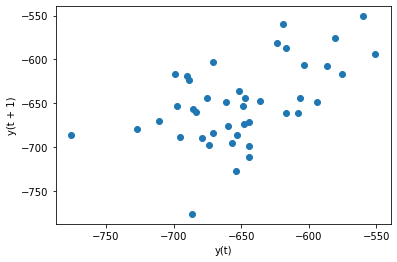

In [5]:
from pandas.plotting import lag_plot
lag_plot(offsets)
plt.show()

In [6]:
values = pd.DataFrame(offsets.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.528014
t+1  0.528014  1.000000


We observe that the amount of vegetation at time $t$ is positivelt correlated with the amount of vegetation at $t-1$, as expected.

## Autocorrelation Function

Plot the autocorrelation function to show how the level of correlation evolves as you look further and further back through the time series. We can see that we are positively correlated at around 12 and 24 months in the past, and negative correlated with 6 and 18 months in the past. This is also expected.

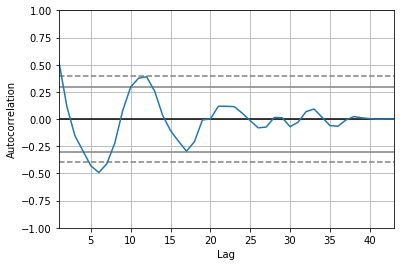

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(offsets)
plt.show()

The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

As we can see the correlation is not currently that significant.

## Using a full autoregressive model

/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


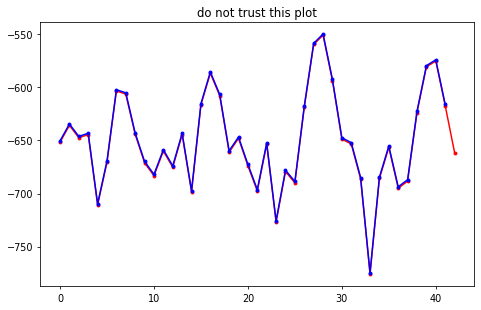

In [8]:
from statsmodels.tsa.ar_model import AR

x = offsets.values
x = pd.to_numeric(x)
model = AR(x)
model_fit = model.fit(maxlag=1, trend='nc')

predictions = model_fit.predict(start=1, end=len(x)-1)
plt.figure(num=None, figsize=(8, 5), dpi=70)
plt.plot(list(x), marker = '.', color = 'red')
plt.plot(list(predictions), marker = '.', color = 'blue')
plt.title('do not trust this plot')
plt.show()

In [9]:
print(model_fit.params)

[0.99803137]


# Detrending

Should try some basic methods first

## STL Decomposition

One issue that we may have with running STL currently is that we have to specify a period $n$ which is the number number of datapoints until the season restarts. Because our underlying seasonality is yearly and our data points are not evenly spaced in a year there is some error here which could through the STL fitting offl

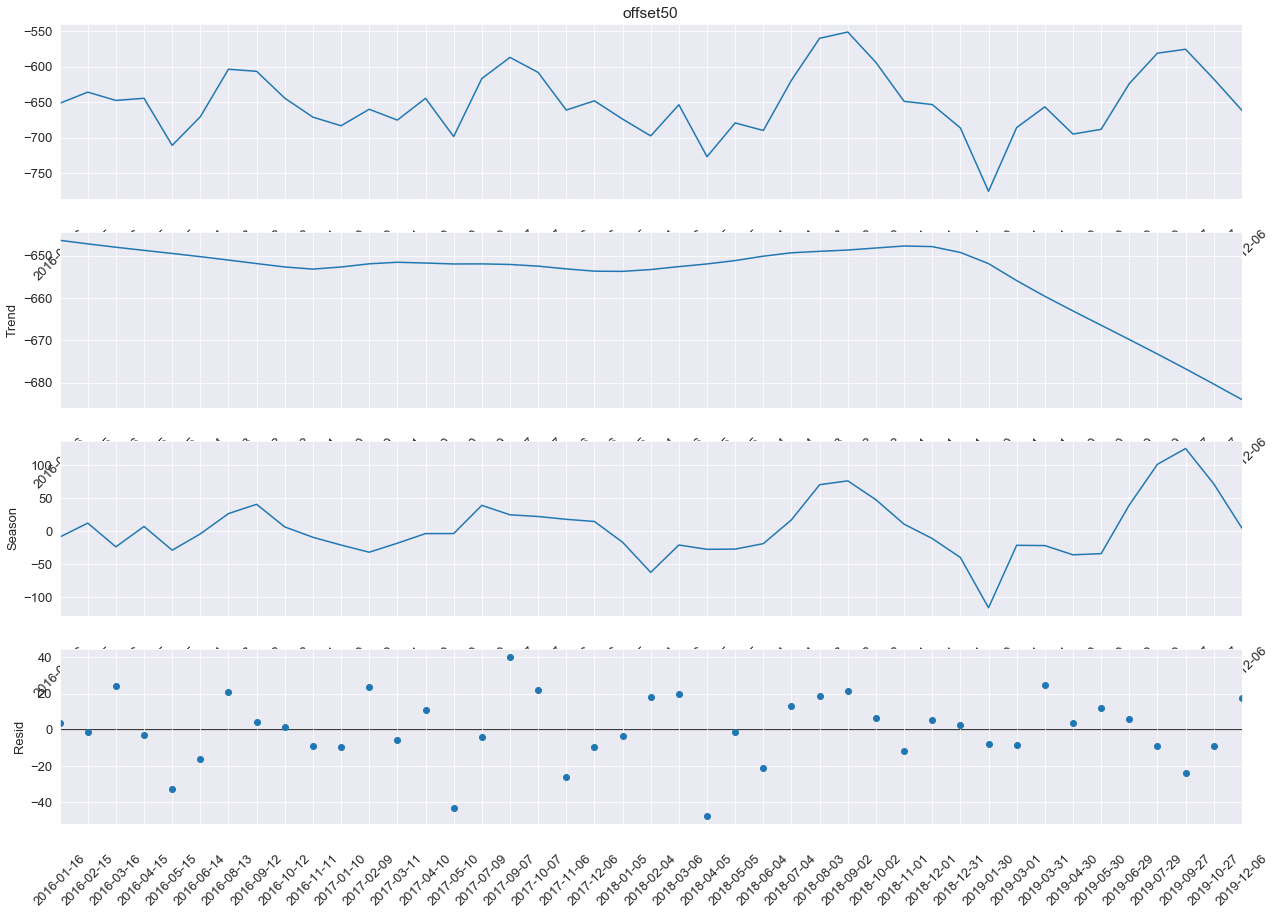

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,12))
plt.rc('font',size=13)

from statsmodels.tsa.seasonal import STL

stl = STL(offsets, seasonal=13, period=12)
res = stl.fit()
fig = res.plot()

ax_list = fig.axes

for ax in ax_list:
    ax.set_xticklabels(offsets.index, rotation = 45, va="center", position=(0,-0.28))